<img src="media/coco-banner.jpg">

### DataSet (combining data) | DataSet (agregar datos)

An Xarray `DataSet` let's you store multiple variables in the same data structure. For example, different physical observables that share the same dimensions. Here we store different [Landsat Bands with their common names](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites):

---

Un `DataSet` es el objecto de Xarray para guardar variables differentes.  Por ejemple, observaciones physicas distintas las cuales comparten las mismas dimensiones. Aqui guardamos landsat bandas diferentes segun su nombre comun:

In [ ]:
import requests
import os

import planetary_computer 
import geopandas as gpd
import pystac_client
import odc.stac

In [16]:
# Open Red Band:
tif = 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/046/027/LC08_L2SP_046027_20210725_20210803_02_T1/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B4.TIF'
output = './data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B4_OV2.tif'

save_local_copy(tif, output)

In [17]:
# Local Copy
daB4 = xr.open_dataarray('./data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B4_OV2.tif', 
                       engine='rasterio',
                      )

# Instead of band=1, use common names for each DataArray
daB4 = daB4.assign_coords(band=['red'])
da = da.assign_coords(band=['nir'])

In [18]:
# Combine along 'band' dimension
da2 = xr.concat([da, daB4], dim='band')
da2

<xarray.DataArray 'band_data' (band: 2, y: 987, x: 972)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) <U3 'nir' 'red'
  * x            (x) float64 4.735e+05 4.737e+05 ... 7.062e+05 7.064e+05
  * y            (y) float64 5.373e+06 5.373e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point

In [19]:
# Convert to a DataSet
ds = da2.to_dataset(dim='band')
ds

<xarray.Dataset>
Dimensions:      (y: 987, x: 972)
Coordinates:
  * x            (x) float64 4.735e+05 4.737e+05 ... 7.062e+05 7.064e+05
  * y            (y) float64 5.373e+06 5.373e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 0
Data variables:
    nir          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    red          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    AREA_OR_POINT:  Point

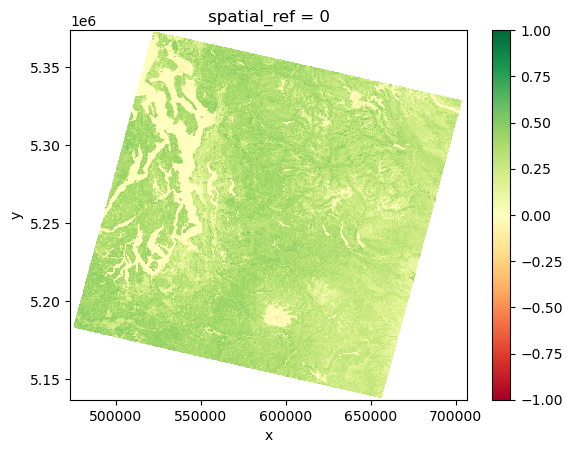

In [20]:
# This tends to be convenient for expressive computations, for example, compute NDVI:
ndvi = (ds.nir - ds.red) / (ds.nir + ds.red)

ndvi.plot(cmap='RdYlGn', vmin=-1, vmax=1);

# Timeseries | Serie de tiempo

If you're interested in computing changes of time, you end up needing to find and read 100s or even 1000s of satellite images. While it is possible to construct DataSets like we did above piece by piece, there are other software packages that build on top of Xarray to simplify this for you. Computations that require a lot of data are best run where the large datasets are hosted. This is why Microsoft [Planetary Computer provides a JupyterHub](https://planetarycomputer.microsoft.com/docs/overview/environment/) in the same region as the data archives.

---

Si quieres calcular cambios por el tiempo, vas a necesitar cienes o miles de imagenes satelitales. Es posible construir DataSets como hicimos arriba poco a poco, pero hay otro software que nos facilita el proceso. Computaciones que requieren muchos datos son muchos mas rapidos si las hace en el mismo centro de datos, es por eso MS Planetary Computer proviene un JupyterHub.

In [21]:
bbox_of_interest = [-122.0, 46.7, -121.5, 47.0]
time_of_interest = "2020-01-01/2022-12-31" #NOTE: L8: 2013, L9: 2021

In [22]:
%%time
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=["landsat-c2-l2"],
                        bbox=bbox_of_interest,
                        datetime=time_of_interest,
                        query={"eo:cloud_cover": {"lt": 10}},
)

items = search.get_all_items()
print(f"Returned {len(items)} Items")

Returned 133 Items
CPU times: user 252 ms, sys: 13.6 ms, total: 265 ms
Wall time: 2.98 s


In [23]:
# Items is a list of GeoJON Features, you can turn it into a GeoPandas table for convenient exploration:
gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
gf.head(3)

,geometry,gsd,created,sci:doi,datetime,platform,proj:epsg,proj:shape,description,instruments,...,landsat:wrs_row,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category
0,"POLYGON ((-121.19176 48.50765, -121.81355 46.8...",30,2023-01-23T23:47:04.269172Z,10.5066/P9OGBGM6,2022-12-12T18:49:59.060473Z,landsat-8,32610,"[7791, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,027,LC80450272022346LGN00,045,2,164.304761,L2SP,17.932540,8.98,02,T1
1,"POLYGON ((-121.71004 47.08426, -122.30887 45.3...",30,2022-11-26T05:29:20.614073Z,10.5066/P9OGBGM6,2022-11-18T18:50:20.606205Z,landsat-9,32610,"[7801, 7691]",Landsat Collection 2 Level-2,"[oli, tirs]",...,028,LC90450282022322LGN00,045,2,165.039502,L2SP,23.301624,3.42,02,T1
2,"POLYGON ((-121.18859 48.50544, -121.81084 46.7...",30,2022-11-26T05:29:18.623076Z,10.5066/P9OGBGM6,2022-11-18T18:49:56.727899Z,landsat-9,32610,"[7781, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,027,LC90450272022322LGN00,045,2,165.630148,L2SP,22.004731,1.48,02,T1


In [24]:
# To integrate nicely with xarray, which uses pandas indices behind the scenes, we can assign a common index (time), as well add columns we might want to keep track of
gf['stac_id'] = [item.id for item in items]
gf['time'] = gpd.pd.to_datetime(gf.datetime) 
gf = gf.set_index('time').tz_localize(None) #drop timezone (UTC)
gf.head(3)

,geometry,gsd,created,sci:doi,datetime,platform,proj:epsg,proj:shape,description,instruments,...,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category,stac_id
time,,,,,,,,,,,,,,,,,,,,,
2022-12-12 18:49:59.060473,"POLYGON ((-121.19176 48.50765, -121.81355 46.8...",30,2023-01-23T23:47:04.269172Z,10.5066/P9OGBGM6,2022-12-12T18:49:59.060473Z,landsat-8,32610,"[7791, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC80450272022346LGN00,045,2,164.304761,L2SP,17.932540,8.98,02,T1,LC08_L2SP_045027_20221212_02_T1
2022-11-18 18:50:20.606205,"POLYGON ((-121.71004 47.08426, -122.30887 45.3...",30,2022-11-26T05:29:20.614073Z,10.5066/P9OGBGM6,2022-11-18T18:50:20.606205Z,landsat-9,32610,"[7801, 7691]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC90450282022322LGN00,045,2,165.039502,L2SP,23.301624,3.42,02,T1,LC09_L2SP_045028_20221118_02_T1
2022-11-18 18:49:56.727899,"POLYGON ((-121.18859 48.50544, -121.81084 46.7...",30,2022-11-26T05:29:18.623076Z,10.5066/P9OGBGM6,2022-11-18T18:49:56.727899Z,landsat-9,32610,"[7781, 7681]",Landsat Collection 2 Level-2,"[oli, tirs]",...,LC90450272022322LGN00,045,2,165.630148,L2SP,22.004731,1.48,02,T1,LC09_L2SP_045027_20221118_02_T1


In [25]:
%%time
ds = odc.stac.stac_load(items, 
                        bands=["nir08", "red"],
                        bbox=bbox_of_interest,
                        resolution=250, # units of output CRS (UTM)
                        groupby='solar_day', # adjacent acquisition frames automatically merged
                        chunks={}, # Use Dask library to divy up large dataset
)
ds

CPU times: user 164 ms, sys: 13.9 ms, total: 178 ms
Wall time: 172 ms


<xarray.Dataset>
Dimensions:      (y: 137, x: 155, time: 81)
Coordinates:
  * y            (y) float64 5.206e+06 5.206e+06 ... 5.173e+06 5.172e+06
  * x            (x) float64 5.761e+05 5.764e+05 ... 6.144e+05 6.146e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-02-21T18:34:19.587648 ... 2022-12...
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>

In [26]:
# There is a lot of STAC metadata we can add to keep track of in this xarray object:
ds = ds.assign_coords(dict(stac_id=gf.stac_id,
                           platform=gf.platform)
                     )


/home/jovyan/.local/envs/odc/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


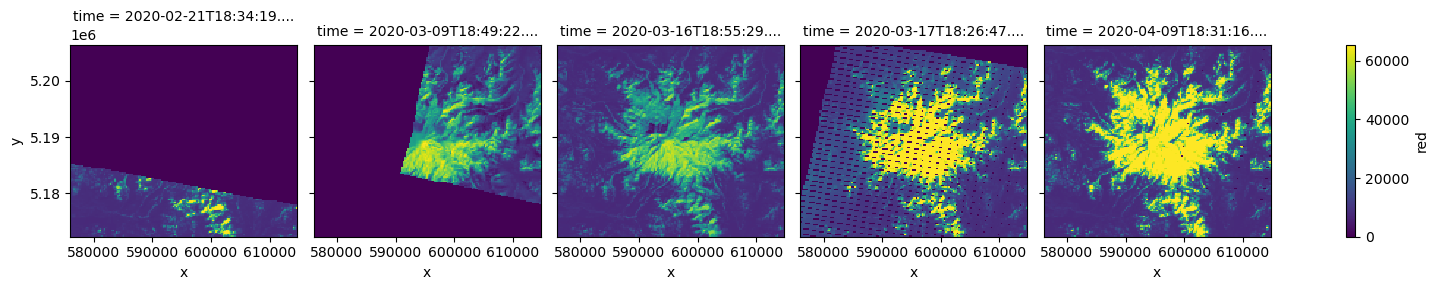

In [27]:
# It is important to understand that satellite images covering the same area of interest have variable coverage:
# Also good to review https://www.usgs.gov/landsat-missions/landsat-collection-2-known-issues 

# Use an xarray 'facet plot' https://docs.xarray.dev/en/stable/generated/xarray.plot.FacetGrid.html # 
ds.red.isel(time=slice(0,5)).plot(col='time');

In [28]:
# ? What's up with 2020-03-17?
ds.sel(time='2020-03-17')
# Image data, just like tabular data often needs significant preprocessing and cleaing
# https://www.usgs.gov/landsat-missions/landsat-7 NOTE the 2020-03-17 acquisition is Landsat 7 which has  Scan Line Corrector issues

<xarray.Dataset>
Dimensions:      (y: 137, x: 155, time: 1)
Coordinates:
  * y            (y) float64 5.206e+06 5.206e+06 ... 5.173e+06 5.172e+06
  * x            (x) float64 5.761e+05 5.764e+05 ... 6.144e+05 6.146e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-03-17T18:26:47.687291
    stac_id      (time) object 'LE07_L2SP_045028_20200317_02_T1'
    platform     (time) object 'landsat-7'
Data variables:
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 137, 155), meta=np.ndarray>

In [29]:
# Operations are lazy
ndvi = (ds.nir08 - ds.red) / (ds.nir08 + ds.red)
ndvi

<xarray.DataArray (time: 81, y: 137, x: 155)>
dask.array<truediv, shape=(81, 137, 155), dtype=float64, chunksize=(1, 137, 155), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.206e+06 5.206e+06 ... 5.173e+06 5.172e+06
  * x            (x) float64 5.761e+05 5.764e+05 ... 6.144e+05 6.146e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-02-21T18:34:19.587648 ... 2022-12...
    stac_id      (time) object 'LE07_L2SP_046028_20200221_02_T1' ... 'LC08_L2...
    platform     (time) object 'landsat-7' 'landsat-8' ... 'landsat-8'

In [30]:
%%time

# Here we actually read 100's of Geotiffs.
# This would be much faster on planetary computer due to minimal data transfer

pixel = ndvi.sel(x=5.9e5, y=5.18e6, method='nearest').compute() # ! Because it's a dask array we need to explicitly compute()!
pixel

CPU times: user 7.75 s, sys: 27 s, total: 34.7 s
Wall time: 1min 6s


<xarray.DataArray (time: 81)>
array([0.11975802,        nan, 0.12112806, 0.20720296, 0.21345085,
       0.13216137, 0.22007528, 0.2457277 ,        nan, 0.26744398,
              nan, 0.28955025, 0.26928675,        nan, 0.26826396,
              nan, 0.28347428,        nan, 0.27303043,        nan,
              nan,        nan, 0.19268702,        nan, 0.16476412,
       0.1931467 ,        nan,        nan, 0.21902486, 0.19355304,
              nan, 0.02093957, 0.03553812, 0.28452949, 0.19500757,
              nan, 0.23233944,        nan, 0.32079886, 0.29694005,
       0.30268168,        nan, 0.30718518, 0.27088036,        nan,
       0.30723938,        nan, 0.29111944, 0.29030504, 0.31922472,
              nan, 0.24797502, 0.25735188,        nan, 0.2053253 ,
       0.14873604,        nan,        nan, 0.2540366 , 0.28593442,
       0.28722329, 0.29872325, 0.28446964,        nan, 0.28779225,
       0.301944  , 0.27605997, 0.29232171, 0.3043674 , 0.28946896,
              nan, 0.2360286 , 0.23727534,        nan, 0.2026811 ,
       0.24431791, 0.21855265, 0.20544979, 0.19855929, 0.17835011,
              nan])
Coordinates:
    y            float64 5.18e+06
    x            float64 5.901e+05
    spatial_ref  int32 32610
  * time         (time) datetime64[ns] 2020-02-21T18:34:19.587648 ... 2022-12...
    stac_id      (time) object 'LE07_L2SP_046028_20200221_02_T1' ... 'LC08_L2...
    platform     (time) object 'landsat-7' 'landsat-8' ... 'landsat-8'

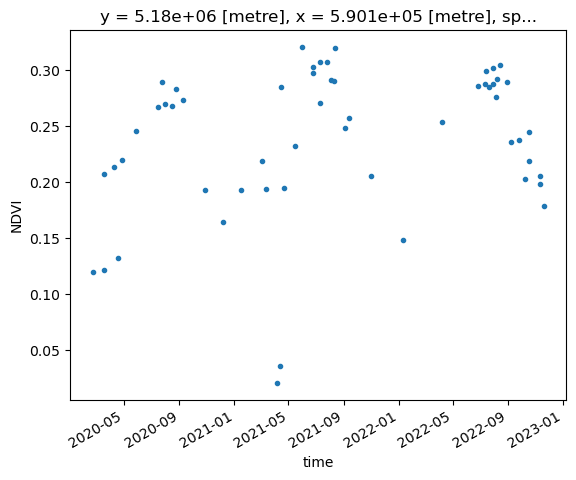

In [31]:
pixel.plot(marker='.', ls='')
plt.ylabel('NDVI');

## Homework | Tarea

* Compute an NDVI Timeseries for an area that you are interested in
* Instead of filtering the entire scene by cloud percentage, use all scenes and mask pixels by estimated cloud coverage
* Compute a different band index like [Normalized Difference Snow Index](https://www.usgs.gov/landsat-missions/normalized-difference-snow-index)
* Try the same workflow but for a different dataset, like [ESA Sentinel-2](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a)
* EXTRA: Combine Landsat8 and Sentinel2 Using the [Harmonized Landsat Sentinel (HLS) Dataset](https://planetarycomputer.microsoft.com/dataset/storage/hls)

---

* Calcular NDVI serie de tiempo para una zona que te interese
* Computar indice de bandas diferente - por ejemplo NDSI
* Intentar seguir el mismo analysis con un sensor diferente (Sentinel-2)
* EXTRA: Combinar Landsat8 y Sentinel2 usando el producto HLS

## Extra material to keep learning | Material extra para seguir aprendiendo

* The [Xarray Tutorial](https://tutorial.xarray.dev/intro.html) has lots of example notebooks from Fundamentals to Advanced
* The [Planetary Computer Documentation](https://planetarycomputer.microsoft.com/docs/overview/about) is extensive, with examples for many important remote sensing datasets.

---

* Xarray Tutorial tiene muchos ejemplos: basicos hasta avanzados.
* MS Planetary Computer Documentacion es amplio, con ejemplos para various archivos organizados por satelite